# USGS Earthquakes Project


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import datetime
import os
import json
import random
from citipy import citipy
import reverse_geocoder as rg


from usgs import api


In [2]:
url = "https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&minlatitude=33&maxlatitude=38&minlongitude=-100&maxlongitude=-93&starttime=2010-01-01&endtime=2020-01-02&minmagnitude=2.5"

new = requests.get(url)
new


<Response [200]>

In [3]:
#new.json()

In [4]:
data = new.json()
mag,coord,time,magType,place,ID = [],[],[],[],[],[]
for result in data['features']:
    mag.append(result[u'properties'][u'mag'])
    coord.append(result[u'geometry'][u'coordinates'])
    time.append(result[u'properties'][u'time'])
    magType.append(result[u'properties'][u'magType'])
    place.append(result[u'properties'][u'place'])
    ID.append(result[u'id'])



quake_df = pd.DataFrame([ID,time,mag,coord,magType,place]).transpose()
time_df = pd.DataFrame([time]).T
eq_df  = quake_df.rename(columns={0: "ID", 1: "Time", 2: "Mag",3: "LatLong", 4: "Mag Type", 5: "Location"})
eq_final_df = eq_df.drop_duplicates(['ID'])
lat = eq_final_df["LatLong"].apply(lambda l: l[0])
long = eq_final_df["LatLong"].apply(lambda l: l[1])
eq_final_df

,ID,Time,Mag,LatLong,Mag Type,Location
0,ok2020aanz,1577862254310,3.08,"[-98.14466667, 36.4115, 7.8]",ml,"19km SE of Helena, Oklahoma"
1,ok2019znrk,1577685475689,3.73,"[-97.91333333, 36.87433333, 7.35]",ml,"16km NW of Medford, Oklahoma"
2,ok2019zeyr,1577273073350,3.38,"[-98.52316667, 35.90733333, 7.53]",ml,"12km WNW of Watonga, Oklahoma"
3,ok2019zerb,1577259237780,2.89,"[-98.1755, 36.29233333, 6.69]",ml,"22km NNE of Okeene, Oklahoma"
4,ok2019zdyd,1577224817820,2.6,"[-98.14716667, 36.30166667, 6.39]",ml,"22km W of Waukomis, Oklahoma"
...,...,...,...,...,...,...
9612,usp000h65r,1263569222320,3.7,"[-97.249, 35.555, 8]",mwr,Oklahoma
9613,usp000h65q,1263568706350,3.8,"[-97.25, 35.576, 8]",mwr,Oklahoma
9614,usp000h63j,1263463534150,3.3,"[-97.238, 35.539, 5]",mblg,Oklahoma
9615,usp000h5y9,1263186960070,2.8,"[-97.259, 35.539, 5]",mblg,Oklahoma


In [5]:
lat = pd.DataFrame(eq_final_df["LatLong"].apply(lambda l: l[1])).rename(columns ={"LatLong":"Lat"})
long = pd.DataFrame(eq_final_df["LatLong"].apply(lambda l: l[0])).rename(columns ={"LatLong":"Long"})
eqDF = eq_final_df.join(lat).join(long)
eqFinalDF = eqDF.drop(['LatLong'], axis = 1)
#eqFinalDF

In [6]:
# This block of code translates and extracts the year out of time stamp from USGS

eqFinalDF_time = pd.DataFrame(pd.to_datetime(eqFinalDF['Time'], unit = "ms"))
eqFinal = eqFinalDF_time.rename(columns = {"Time":"New Time"})
eqFinal['year'] = pd.DatetimeIndex(eqFinal['New Time']).year
eqFinal.head()

eqFinalDF['Time'] = eqFinal['year']
#eqFinalDF

In [7]:

# this block of code isolates the location information using a reverse geocoding module
subset = eqFinalDF[['Lat', 'Long']]
tuples = [tuple(x) for x in subset.to_numpy()]

def reversegeo(coordinates):
    county_result = rg.search(coordinates)
    county_result = [dict(d) for d in county_result]
    
    return county_result

coordinates = (tuples)
l = reversegeo(coordinates)


Loading formatted geocoded file...


In [20]:
#This block of code extracts the county name out of the dictionary from the reverse geocoding workflow and places it in a column associated with each seismic event
testDF = pd.DataFrame(l)
countyDF = testDF.rename(columns={"admin2":"County", "admin1":"State","name":"City"})
County_it1 = countyDF.County.apply(lambda x:pd.Series(str(x).split(" ")))
County_it2 = County_it1.rename(columns={0:"County",1:"Extra"})
County_it2.drop(["Extra",2],axis=1)

eqFinalDF['County'] = County_it2['County']
eqFinalDF['City'] = countyDF['City']
city_df = pd.DataFrame(eqFinalDF.groupby('City')['ID'].nunique())
cityDF = city_df.sort_values(by=['ID'], ascending = True)
eqFinalDF.head()

,ID,Time,Mag,Mag Type,Location,Lat,Long,County,City
0,ok2020aanz,2020,3.08,ml,"19km SE of Helena, Oklahoma",36.411500,-98.144667,Alfalfa,Helena
1,ok2019znrk,2019,3.73,ml,"16km NW of Medford, Oklahoma",36.874333,-97.913333,Grant,Medford
2,ok2019zeyr,2019,3.38,ml,"12km WNW of Watonga, Oklahoma",35.907333,-98.523167,Blaine,Watonga
3,ok2019zerb,2019,2.89,ml,"22km NNE of Okeene, Oklahoma",36.292333,-98.175500,Blaine,Okeene
4,ok2019zdyd,2019,2.6,ml,"22km W of Waukomis, Oklahoma",36.301667,-98.147167,Garfield,Waukomis


In [9]:
# plt.style.use('ggplot')
# plt.figure(figsize=(9, 14))
# city = cityDF['City']
# eq = cityDF['ID']

# plt.bar(city, eq, color='red')
# plt.xlabel("City Name")
# plt.xticks(city, rotation=90)
# plt.ylabel("Event count")
# plt.title("Shakiest City in Ok")


# plt.show()

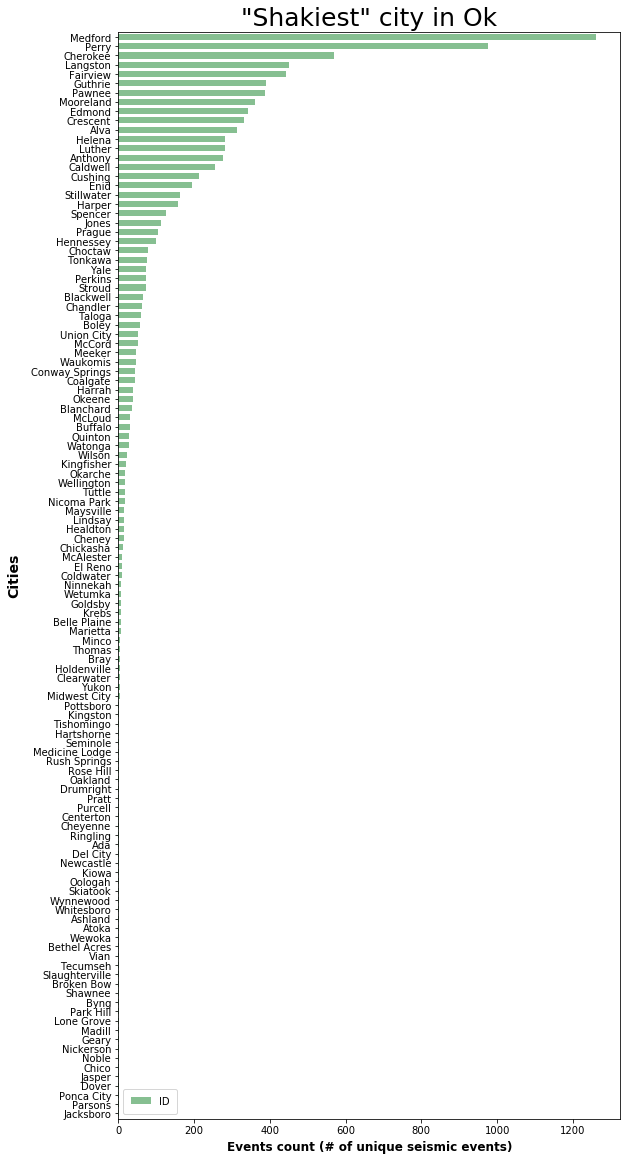

In [21]:

# Define the ax parameters using the formatted DF frm abve

ax = cityDF.plot(kind='barh', figsize=(9, 20), color='#86bf91', zorder=2, width=0.65)
ax.set_title('"Shakiest" city in Ok', size = 25)

# Set x-axis label
ax.set_xlabel("Events count (# of unique seismic events)", labelpad=5, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Cities", labelpad = 10,  weight='bold', size=14)
ax.legend(fancybox = True, borderpad = .75)
plt.show()